# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [ ]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import IPython.display as display
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
2021-04-19 10:50:33,301 - INFO - font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/co

### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [ ]:
# 解压数据
!unzip -q data/data79149/cartoon_A2B.zip -d data/

### 数据可视化

训练集数据量: 1361
测试集数据量: 100


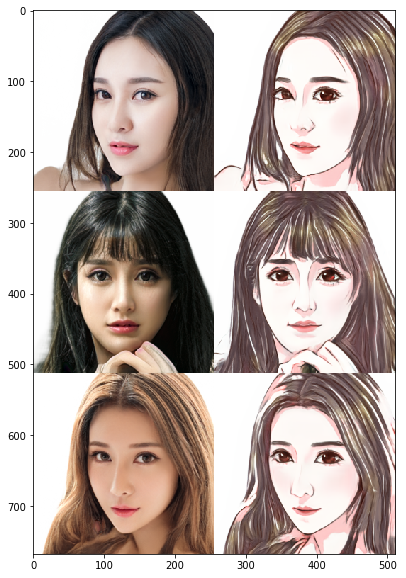

In [ ]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [ ]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])                                        # 读取一组数据
        img_A2B = (img_A2B / 255. * 2. - 1.).astype('float32')                                        # 从0~255归一化至-1~1
        img_A2B = np.transpose(img_A2B, (2, 0, 1))                                        # 维度变换HWC -> CHW
        img_A = img_A2B[:, :, :256]                                          # 真人照
        img_B = img_A2B[:, :, 256:]                                           # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]


In [ ]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

## 第一步：搭建生成器

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [ ]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            nn.LeakyReLU(.2),                    # LeakyReLU, leaky=0.2
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding),                    # Conv2D
            nn.BatchNorm2D(out_dim),                    # BatchNorm2D
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),                    # ReLU
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding),                    # Conv2DTranspose
            nn.BatchNorm2D(out_dim),                    # nn.BatchNorm2D
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [ ]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding),                    # Conv2D
            nn.BatchNorm2D(out_dim),                    # BatchNorm2D
            nn.LeakyReLU(.2),                    # LeakyReLU, leaky=0.2
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()


In [ ]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30]

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


In [ ]:
# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 100

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )



In [ ]:
# 读取用于测试实时训练效果的图片
test_names = os.listdir('data/cartoon_A2B/test')
img_name = np.random.choice(test_names)
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, :256]                                  # 真人照
img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor


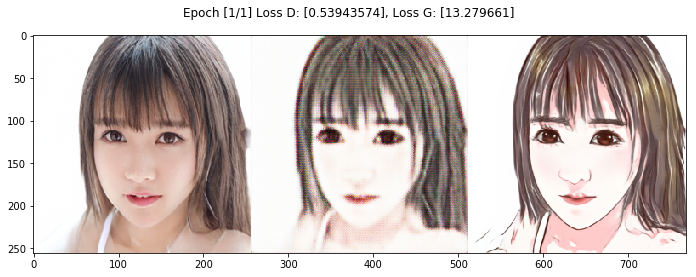

In [ ]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in data_loader_train:
        real_A, real_B = data
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A.detach())
        fake_AB = paddle.concat((real_A, fake_B), 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_real_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A, fake_B), 1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(d_real_predict))
        g_l1_loss = l1_loss(real_B, fake_B)
        g_loss = g_bce_loss + g_l1_loss * 100.
        
        # train G
        g_loss.backward()
        optimizerG.step()

        # 实时查看训练效果
        g_output = generator(g_input)
        g_output = g_output.detach().numpy()                      # tensor -> numpy
        g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
        g_output = g_output * 127.5 + 127.5                       # 反归一化
        g_output = g_output.astype(np.uint8)

        img_show = np.hstack([img_A, g_output, img_B])[:,:,::-1]
        plt.figure(figsize=(12, 4))
        plt.suptitle(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')
        plt.imshow(img_show)
        plt.show()
        display.clear_output(wait=True)

    # print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()


## 最后：用你补齐的代码试试卡通化的效果吧！

In [ ]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights/epoch100.pdparams


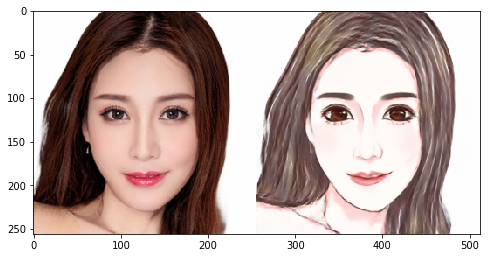

In [ ]:
# 读取数据
test_names = os.listdir('data/cartoon_A2B/test')
img_name = np.random.choice(test_names)
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, :256]                                  # 真人照
img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()